<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Daria-Petrova-folder/Petrova%20Daria/Iris_ID_6_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ТЗ**

**Задача:** идентификация пациента по радужной оболочке глаза (Iris ID).

**Тип задачи:** классификация.
Количество классов: равно удвоенному количеству пациентов (левый и
правый глаза).

**Датасет:** цветные изображения переднего сегмента глаз в формате png с
разрешением 1920x1080. В качестве источника датасета задействованы 10
человек. По 50 снимков на каждый глаз (всего 1000 снимков). При
необходимости количество снимков можно будет увеличить.
Задействованных людей можно будет использовать для тестирования
обученной сети.

**Особенности:** возможность дообучения на датасете, содержащем новые
классы.

**Точность:** FRR (ложный недопуск) ошибка не более 3%, FAR (ложный
допуск) ошибка не более 3%, идентификация: точность не менее 97%.

**Описание идентификации:**

На вход системы идентификации подается изображение переднего сегмента
правого глаза пациента. С помощью сети сегментации (разработанной на
предыдущем этапе) извлекается область радужной оболочки и зрачка.
Вычисляется соотношение диаметра зрачка к диаметру радужной оболочки.
Если это соотношение более, чем 0,5 (слишком расширенный зрачок), то
система идентификации возвращает «невозможность идентификации», т. е.
область радужной оболочки слишком мала для возможности точной
идентификации. Эта область подается на сеть классификации. Сеть
классификации возвращает вероятность класса для правого глаза. Затем
подается изображение переднего сегмента левого глаза пациента и снова
возвращается вероятность класса. Если вероятность класса хотя бы для
одного из двух глаз ниже 97%, то система идентификации возвращает
«недопуск», т. е. отсутствие пациента в системе идентификации.

# **Описание НС**

**Имеется:** папка IrisID на Google Drive, в которую будут загружаться датасеты для обучения нейросети в виде архивов с наименованиями пациентов.

Данная программа обновляет и обрабатывает новые файлы и папки в папке IrisID на Google Drive. Затем происходит аугментация изображений, разделение датасета на обучающую и тестовую выборки, и, при необходимости, повторная проверка наличия новых файлов и папок для последующей обработки. Этот процесс позволяет автоматически интегрировать новые данные в существующий датасет и готовить его для обучения и дообучения нейросети.

## **I. Работа с новыми датасетами.**

Этот этап необходим для проверки наличия новых датасетов в исходной папке IrisID на Google Drive и добавления их в директорию Google Colab.

**Подключение к Google Drive.**

Программа начинает с подключения к Google Drive с помощью drive.mount('/content/drive'). После успешного подключения получаем доступ к файлам и папкам на Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Импортирование папки с датасетами из Google Drive в директорию Google Colab.**

Затем программа импортирует папку IrisID из Google Drive в директорию Google Colab. Для этого используется shutil.copytree(drive_folder_path, colab_folder_path), где drive_folder_path - путь к папке IrisID на Google Drive, а colab_folder_path - путь к папке IrisID в директории Google Colab. С помощью os.path.exists(colab_folder_path) проверяется условие, существует ли уже папка IrisID в директории Google Colab. Если папка уже существует, выводится сообщение "Папка IrisID уже существует в директории Google Colab". Если папки нет, то выполняется копирование файлов из Google Drive в Google Colab.






In [ ]:
import shutil
import os

# Путь к папке на Google Drive, в которую будут загружаться новые данные
drive_folder_path = '/content/drive/MyDrive/IrisID'

# Путь к папке в директории Google Colab
colab_folder_path = '/content/IrisID'

if not os.path.exists(colab_folder_path):
    # Копирование файлов из Google Drive в Google Colab
    os.makedirs(colab_folder_path)
    
    # Копирование файлов из Google Drive в Google Colab
for file_name in os.listdir(drive_folder_path):
    src = os.path.join(drive_folder_path, file_name)
    dst = os.path.join(colab_folder_path, file_name)
    shutil.copy(src, dst)

else:
    print("Папка IrisID уже существует в директории Google Colab.")

Папка IrisID уже существует в директории Google Colab.


**Проверка наличия новых архивов в папке IrisID в директории Google Colab.**

In [ ]:
archives = [f for f in os.listdir(drive_folder_path) if f.endswith('.zip')]

if len(archives) == 0:
    print("Архивы отсутствуют в папке IrisID на Google Drive.")
else:
    print("Найдены следующие архивы в папке IrisID на Google Drive:")
    print('\n'.join(archives))

# Путь к файлу, в котором будет храниться список предыдущих архивов
# (с момента последнего пополенения папки IrisID на Google Drive)
previous_archives_file = '/content/previous_archives.txt'

# Проверка наличия предыдущего списка архивов
if os.path.exists(previous_archives_file):
    # Загрузка предыдущего списка архивов
    with open(previous_archives_file, 'r') as file:
        previous_archives = file.read().splitlines()
else:
    previous_archives = []

# Проверка наличия новых архивов и отображение их в виде списка
new_archives = [archive for archive in archives if archive not in previous_archives]

print("Среди них новых архивов:", end=" ")
if len(new_archives) == 0:
    print("нет.")
else:
    print(f"{len(new_archives)}")
    print('\n'.join(new_archives))

# Объединение текущего списка архивов с предыдущими
updated_archives = previous_archives + archives

# Сохранение обновлённого списка архивов
with open(previous_archives_file, 'w') as file:
    file.write('\n'.join(updated_archives))

Найдены следующие архивы в папке IrisID на Google Drive:
iris1_8.zip
iris9_16.zip
Среди них новых архивов: нет.


**Распаковка новых архивов и сортировка изображений по папкам классов.**

Новые архивы из папки IrisID на Google Drive извлекаются с помощью функции extract_archives и размещаются в папку IDs в директории Google Colab. Код проверяет наличие папки с именем архива внутри папки IDs перед извлечением. Если папка уже существует, архив пропускается. 

In [ ]:
import zipfile
import glob

def extract_archives():
    # Пути к папкам
    ids_path = os.path.join(colab_folder_path, 'IDs')

    # Распаковка архивов
    archives = glob.glob(os.path.join(colab_folder_path, '*.zip'))
    for archive in archives:
        archive_name = os.path.splitext(os.path.basename(archive))[0]
        extraction_path = os.path.join(ids_path, archive_name)

        # Проверка наличия папки с именем архива внутри папки IDs
        if not os.path.exists(extraction_path):
            with zipfile.ZipFile(archive, 'r') as zip_ref:
                # Получение списка файлов в архиве
                file_list = zip_ref.namelist()

                # Проверка наличия основной директории в архиве
                has_main_directory = False
                for file in file_list:
                    if '/' in file:
                        has_main_directory = True
                        break

                # Если основная директория отсутствует, создаём папку с названием архива внутри IDs
                if not has_main_directory:
                    extraction_path = os.path.join(ids_path, archive_name)
                    os.makedirs(extraction_path)

                # Извлечение файлов
                zip_ref.extractall(extraction_path)
            os.remove(archive)
        else:
            print(f"Архив {archive_name} уже распакован.")
            os.remove(archive)
            
extract_archives()

**Полная очистка папки IDs от содержимого, при необходимости.**

Этот код использует функцию shutil.rmtree() для удаления содержимого папки IDs. Затем функция os.makedirs() создаёт пустую папку IDs, чтобы была возможность начать с чистого листа при необходимости.

In [ ]:
def clear_ids_folder():
      
    # Удаление содержимого папки IDs
    shutil.rmtree(colab_folder_path)
    
    # Пересоздание пустой папки IDs
    os.makedirs(colab_folder_path)

    extract_archives()

# Вызов функции для очистки папки IDs
clear_ids_folder()

## **II. Обработка изображений.**

### **Разделение датасетов на train и test выборки.**

Ниже приведен код, который берёт изображения из всех папок в папке IDs, копирует их и распределяет на две новые папки train и test в папке IrisID в директории Colab.

При каждом обновлении ячейки он автоматически очищет папки train и test от содержимого и затем распределяет изображения в случайном порядке - это позволяет избежать дублирования информации.

In [21]:
import random

def clear_directory(directory):
    # Очистка содержимого папки
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

def create_train_test_split():
    # Пути к папкам
    ids_path = '/content/IrisID/IDs'
    train_path = '/content/IrisID/train'
    test_path = '/content/IrisID/test'

    # Создание папок train и test, если они не существуют
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # Очистка содержимого папок train и test
    clear_directory(train_path)
    clear_directory(test_path)

    # Получение списка всех папок внутри IDs
    folders = [folder for folder in os.listdir(ids_path) if os.path.isdir(os.path.join(ids_path, folder))]

    for folder in folders:
        folder_path = os.path.join(ids_path, folder)
        files = os.listdir(folder_path)

        # Перемешивание списка файлов
        random.shuffle(files)

        # Определение количества файлов для тренировочной и тестовой выборок (80% для тренировки, 20% для теста)
        split_index = int(0.8 * len(files))
        train_files = files[:split_index]
        test_files = files[split_index:]

        # Перемещение файлов в папки train и test
        for file in train_files:
            src = os.path.join(folder_path, file)
            dst = os.path.join(train_path, "train_" + file)
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(folder_path, file)
            dst = os.path.join(test_path, "test_" + file)
            shutil.copy(src, dst)

# Вызов функции для создания тренировочной и тестовой выборок
create_train_test_split()

### **Аугментация изображений в выборках.**

Для аугментации изображений радужных оболочек глаз можно использовать несколько техник, которые помогут улучшить разнообразие данных и сделать модель более робастной. Вот некоторые из них:



1.  Горизонтальное отражение: Поворот изображений по горизонтали может создать зеркальное отражение радужной оболочки. Это помогает модели обучиться на различных ориентациях и симметрии.
2.  Изменение яркости и контраста: Модификация яркости и контраста изображений может помочь модели обучиться на различных условиях освещения и яркости радужной оболочки.
3.  Изменение размера и масштабирование: Варьируя размер и масштаб изображений, можно создать разные варианты радужной оболочки, что помогает модели обучиться на различных размерах и формах.
4.  Аффинные преобразования: Аффинные преобразования, такие как поворот, масштабирование, сдвиг и сдвиг с искажением, могут помочь модели обучиться на различных позах и вариациях радужной оболочки.
5.  Добавление шума: Добавление случайного шума к изображениям может помочь модели стать более устойчивой к шуму и неровностям на радужной оболочке.
6.  Кропы и рандомизация позиции: Случайные кропы изображений и рандомизация позиции радужной оболочки внутри изображения могут помочь модели обучиться на различных расположениях и размерах оболочки.

In [22]:
import cv2
import numpy as np
import os

def augment_images(directory):
    # Получение списка файлов в папке
    files = os.listdir(directory)

    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            # Полный путь к файлу
            file_path = os.path.join(directory, file)

            # Загрузка изображения
            image = cv2.imread(file_path)

            # Горизонтальное отражение
            flipped = cv2.flip(image, 1)
            flipped_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            flipped_file_path = os.path.join(directory, flipped_file)
            cv2.imwrite(flipped_file_path, flipped)

            # Изменение яркости и контраста
            brightness = np.random.uniform(0.7, 1.3)
            contrast = np.random.uniform(0.7, 1.3)
            adjusted = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
            adjusted_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            adjusted_file_path = os.path.join(directory, adjusted_file)
            cv2.imwrite(adjusted_file_path, adjusted)

            # Изменение размера и масштабирование
            scale_factor = np.random.uniform(0.8, 1.2)
            resized = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
            resized_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            resized_file_path = os.path.join(directory, resized_file)
            cv2.imwrite(resized_file_path, resized)

            # Аффинные преобразования
            rows, cols, _ = image.shape
            rotation_angle = np.random.uniform(-10, 10)
            translation_x = np.random.uniform(-cols * 0.1, cols * 0.1)
            translation_y = np.random.uniform(-rows * 0.1, rows * 0.1)
            shear_angle = np.random.uniform(-10, 10)

            M = cv2.getRotationMatrix2D((cols // 2, rows // 2), rotation_angle, 1)
            M[:, 2] += (translation_x, translation_y)
            M[0, 1] += shear_angle * 0.1

            transformed = cv2.warpAffine(image, M, (cols, rows))
            transformed_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            transformed_file_path = os.path.join(directory, transformed_file)
            cv2.imwrite(transformed_file_path, transformed)

            # Добавление шума
            noise = np.random.normal(loc=0, scale=10, size=image.shape).astype(np.uint8)
            noisy = cv2.add(image, noise)
            noisy_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            noisy_file_path = os.path.join(directory, noisy_file)
            cv2.imwrite(noisy_file_path, noisy)

            # Кропы и рандомизация позиции
            crop_x = np.random.randint(0, cols // 2)
            crop_y = np.random.randint(0, rows // 2)
            cropped = image[crop_y:rows - crop_y, crop_x:cols - crop_x]
            cropped_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
            cropped_file_path = os.path.join(directory, cropped_file)
            cv2.imwrite(cropped_file_path, cropped)

# Путь к папке "train"
train_path = '/content/IrisID/train'
# Путь к папке "test"
test_path = '/content/IrisID/test'

# Вызов функции аугментации для папки "train"
augment_images(train_path)

# Вызов функции аугментации для папки "test"
augment_images(test_path)

**Демонстрация случайного изображения из выборки train.**

Этот код выбирает случайное изображение из папки train и отображает его с помощью библиотеки matplotlib.

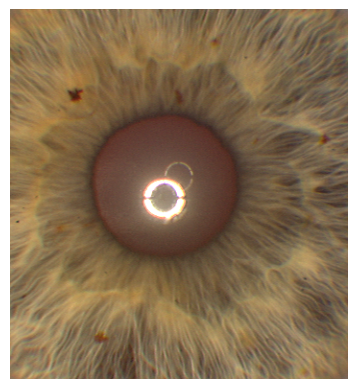

In [34]:
import matplotlib.pyplot as plt
from PIL import Image

def display_random_image(train_path):
    # Получение списка всех файлов в папке train
    files = os.listdir(train_path)

    # Случайный выбор изображения
    random_file = random.choice(files)
    image_path = os.path.join(train_path, random_file)

    # Загрузка и отображение изображения
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Путь к папке train
train_path = '/content/IrisID/train'

# Вызов функции для отображения случайного изображения
display_random_image(train_path)

### **Автоматическое повторение предыдущих этапов (перераспределение новых датасетов на выборки и аугментация новых изображений).**

Шаги 1 и 2 можно автоматически проделывать обновлением одной ячейки.

In [10]:
import random

def clear_directory(directory):
    # Очистка содержимого папки
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

def create_train_test_split():
    # Пути к папкам
    ids_path = '/content/IrisID/IDs'
    train_path = '/content/IrisID/train'
    test_path = '/content/IrisID/test'

    # Создание папок train и test, если они не существуют
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # Очистка содержимого папок train и test
    clear_directory(train_path)
    clear_directory(test_path)

    # Получение списка всех папок внутри IDs
    folders = [folder for folder in os.listdir(ids_path) if os.path.isdir(os.path.join(ids_path, folder))]

    for folder in folders:
        folder_path = os.path.join(ids_path, folder)
        files = os.listdir(folder_path)

        # Перемешивание списка файлов
        random.shuffle(files)

        # Определение количества файлов для тренировочной и тестовой выборок (80% для тренировки, 20% для теста)
        split_index = int(0.8 * len(files))
        train_files = files[:split_index]
        test_files = files[split_index:]

        # Перемещение файлов в папки train и test
        for file in train_files:
            src = os.path.join(folder_path, file)
            dst = os.path.join(train_path, "train_" + file)
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(folder_path, file)
            dst = os.path.join(test_path, "test_" + file)
            shutil.copy(src, dst)

# Вызов функции для создания тренировочной и тестовой выборок
create_train_test_split()

def augment_images():
    # Путь к папке train
    train_path = '/content/IrisID/train'



# Вызов функции для применения аугментации к изображениям в папке train
augment_images()

# **ДОПОЛНИТЕЛЬНО: автоматическое повторение этапов I и II.**

Проверка наличия новых датасетов в папке IrisID на Google Drive, и, при обнаружении, - добавление их в директорию Google Colab, аугментация и перераспределение в train и test выборки.

Подключение к Google Drive.

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Функция process_new_archives() содержит все шаги для обработки новых архивов и выполнения всех последующих действий.

In [56]:
#@title
import shutil
import os
import zipfile
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def process_new_archives():

    # Шаг 1: Поиск новых архивов в папке IrisID на Google Drive

    # Путь к папке на Google Drive, в которую будут загружаться новые данные
    drive_folder_path = '/content/drive/MyDrive/IrisID'

    # Путь к папке в директории Google Colab
    colab_folder_path = '/content/IrisID'

    if not os.path.exists(colab_folder_path):
        # Копирование файлов из Google Drive в Google Colab
        os.makedirs(colab_folder_path)
        
        # Копирование файлов из Google Drive в Google Colab
    for file_name in os.listdir(drive_folder_path):
        src = os.path.join(drive_folder_path, file_name)
        dst = os.path.join(colab_folder_path, file_name)
        shutil.copy(src, dst)

    else:
        print("Папка IrisID уже существует в директории Google Colab.")

    # Шаг 2: Распаковка архивов в папку IDs

    archives = [f for f in os.listdir(drive_folder_path) if f.endswith('.zip')]

    if len(archives) == 0:
        print("Архивы отсутствуют в папке IrisID на Google Drive.")
    else:
        print("Найдены следующие архивы в папке IrisID на Google Drive:")
        print('\n'.join(archives))

    # Путь к файлу, в котором будет храниться список предыдущих архивов
    # (с момента последнего пополенения папки IrisID на Google Drive)
    previous_archives_file = '/content/previous_archives.txt'

    # Проверка наличия предыдущего списка архивов
    if os.path.exists(previous_archives_file):
        # Загрузка предыдущего списка архивов
        with open(previous_archives_file, 'r') as file:
            previous_archives = file.read().splitlines()
    else:
        previous_archives = []

    # Проверка наличия новых архивов и отображение их в виде списка
    new_archives = [archive for archive in archives if archive not in previous_archives]

    print("Среди них новых архивов:", end=" ")
    if len(new_archives) == 0:
        print("нет.")
    else:
        print(f"{len(new_archives)}")
        print('\n'.join(new_archives))

    # Объединение текущего списка архивов с предыдущими
    updated_archives = previous_archives + archives

    # Сохранение обновлённого списка архивов
    with open(previous_archives_file, 'w') as file:
        file.write('\n'.join(updated_archives))

    def extract_archives():
        # Пути к папкам
        ids_path = os.path.join(colab_folder_path, 'IDs')

        # Распаковка архивов
        archives = glob.glob(os.path.join(colab_folder_path, '*.zip'))
        for archive in archives:
            archive_name = os.path.splitext(os.path.basename(archive))[0]
            extraction_path = os.path.join(ids_path, archive_name)

            # Проверка наличия папки с именем архива внутри папки IDs
            if not os.path.exists(extraction_path):
                with zipfile.ZipFile(archive, 'r') as zip_ref:
                    # Получение списка файлов в архиве
                    file_list = zip_ref.namelist()

                    # Проверка наличия основной директории в архиве
                    has_main_directory = False
                    for file in file_list:
                        if '/' in file:
                            has_main_directory = True
                            break

                    # Если основная директория отсутствует,
                    # создаём папку с названием архива внутри IDs
                    if not has_main_directory:
                        extraction_path = os.path.join(ids_path, archive_name)
                        os.makedirs(extraction_path)

                    # Извлечение файлов
                    zip_ref.extractall(extraction_path)
                os.remove(archive)
            else:
                print(f"Архив {archive_name} уже распакован.")
                os.remove(archive)

    extract_archives()

    # Функция для полной очистки папки IDs от содержимого
    def clear_ids_folder():
        
        # Удаление содержимого папки IDs
        shutil.rmtree(colab_folder_path)
        
        # Пересоздание пустой папки IDs
        os.makedirs(colab_folder_path)

    # Шаг 3: Разделение датасетов на выборки.

    def clear_directory(directory):
        # Очистка содержимого папки
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

    def create_train_test_split():
        # Пути к папкам
        ids_path = '/content/IrisID/IDs'
        train_path = '/content/IrisID/train'
        test_path = '/content/IrisID/test'

        # Создание папок train и test, если они не существуют
        if not os.path.exists(train_path):
            os.makedirs(train_path)
        if not os.path.exists(test_path):
            os.makedirs(test_path)

        # Очистка содержимого папок train и test
        clear_directory(train_path)
        clear_directory(test_path)

        # Получение списка всех папок внутри IDs
        folders = [folder for folder in os.listdir(ids_path) if os.path.isdir(os.path.join(ids_path, folder))]

        for folder in folders:
            folder_path = os.path.join(ids_path, folder)
            files = os.listdir(folder_path)

            # Перемешивание списка файлов
            random.shuffle(files)

            # Определение количества файлов для тренировочной и тестовой выборок (80% для тренировки, 20% для теста)
            split_index = int(0.8 * len(files))
            train_files = files[:split_index]
            test_files = files[split_index:]

            # Перемещение файлов в папки train и test
            for file in train_files:
                src = os.path.join(folder_path, file)
                dst = os.path.join(train_path, "train_" + file)
                shutil.copy(src, dst)

            for file in test_files:
                src = os.path.join(folder_path, file)
                dst = os.path.join(test_path, "test_" + file)
                shutil.copy(src, dst)

    # Вызов функции для создания тренировочной и тестовой выборок
    create_train_test_split()
    
    # Шаг 4: Аугментация.
    def augment_images(directory):
        # Получение списка файлов в папке
        files = os.listdir(directory)

        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                # Полный путь к файлу
                file_path = os.path.join(directory, file)

                # Загрузка изображения
                image = cv2.imread(file_path)

                # Горизонтальное отражение
                flipped = cv2.flip(image, 1)
                flipped_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                flipped_file_path = os.path.join(directory, flipped_file)
                cv2.imwrite(flipped_file_path, flipped)

                # Изменение яркости и контраста
                brightness = np.random.uniform(0.7, 1.3)
                contrast = np.random.uniform(0.7, 1.3)
                adjusted = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
                adjusted_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                adjusted_file_path = os.path.join(directory, adjusted_file)
                cv2.imwrite(adjusted_file_path, adjusted)

                # Изменение размера и масштабирование
                scale_factor = np.random.uniform(0.8, 1.2)
                resized = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
                resized_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                resized_file_path = os.path.join(directory, resized_file)
                cv2.imwrite(resized_file_path, resized)

                # Аффинные преобразования
                rows, cols, _ = image.shape
                rotation_angle = np.random.uniform(-10, 10)
                translation_x = np.random.uniform(-cols * 0.1, cols * 0.1)
                translation_y = np.random.uniform(-rows * 0.1, rows * 0.1)
                shear_angle = np.random.uniform(-10, 10)

                M = cv2.getRotationMatrix2D((cols // 2, rows // 2), rotation_angle, 1)
                M[:, 2] += (translation_x, translation_y)
                M[0, 1] += shear_angle * 0.1

                transformed = cv2.warpAffine(image, M, (cols, rows))
                transformed_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                transformed_file_path = os.path.join(directory, transformed_file)
                cv2.imwrite(transformed_file_path, transformed)

                # Добавление шума
                noise = np.random.normal(loc=0, scale=10, size=image.shape).astype(np.uint8)
                noisy = cv2.add(image, noise)
                noisy_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                noisy_file_path = os.path.join(directory, noisy_file)
                cv2.imwrite(noisy_file_path, noisy)

                # Кропы и рандомизация позиции
                crop_x = np.random.randint(0, cols // 2)
                crop_y = np.random.randint(0, rows // 2)
                cropped = image[crop_y:rows - crop_y, crop_x:cols - crop_x]
                cropped_file = os.path.splitext(file)[0] + '_augm' + os.path.splitext(file)[1]
                cropped_file_path = os.path.join(directory, cropped_file)
                cv2.imwrite(cropped_file_path, cropped)

    # Путь к папке "train"
    train_path = '/content/IrisID/train'
    # Путь к папке "test"
    test_path = '/content/IrisID/test'

    # Вызов функции аугментации для папки "train"
    augment_images(train_path)

    # Вызов функции аугментации для папки "test"
    augment_images(test_path)

    # Отображение случайного изображения из тренировочной выборки
    def display_random_image(train_path):
        # Получение списка всех файлов в папке train
        files = os.listdir(train_path)

        # Случайный выбор изображения
        random_file = random.choice(files)
        image_path = os.path.join(train_path, random_file)

        # Загрузка и отображение изображения
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    # Путь к папке train
    train_path = '/content/IrisID/train'

В ячейке ниже, где вызывается функция process_new_archives(), она будет выполнять все шаги автоматически.

In [ ]:
#@title Вызов функции для обработки новых архивов и выполнения всех шагов
process_new_archives()

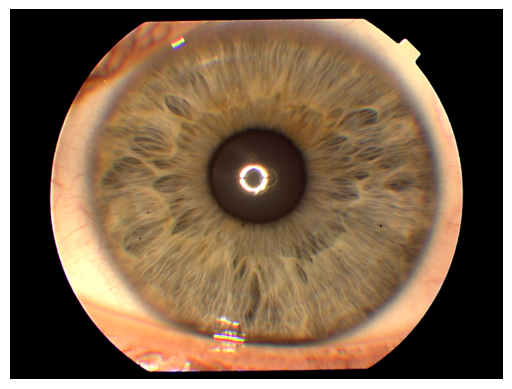

In [60]:
#@title Вызов функции для отображения случайного изображения
display_random_image(train_path)

Всё содержимое папки IrisID можно очистить, если была допущена какая-либо ошибка...

In [ ]:
#@title
# Вызов функции для очистки папки IrisID
clear_ids_folder()

... И проделать этапы I-II заново.